In [637]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import pylab

import xgboost as xgb
from sklearn.metrics import roc_auc_score, r2_score

In [638]:
# Read from csv.
train_data = pd.read_csv('./Nepal/train_values.csv')
train_labels = pd.read_csv('./Nepal/train_labels.csv')
test_data = pd.read_csv('./Nepal/test_values.csv')

In [639]:
target = ['damage_grade']

In [640]:
pd.options.display.max_rows = 4000

# Data Exploration

In [641]:
#train_labels.describe()

In [642]:
train_data['age'].describe()

count    10000.000000
mean        25.393500
std         64.482893
min          0.000000
25%         10.000000
50%         15.000000
75%         30.000000
max        995.000000
Name: age, dtype: float64

In [643]:
train_data['height'].median()

5.0

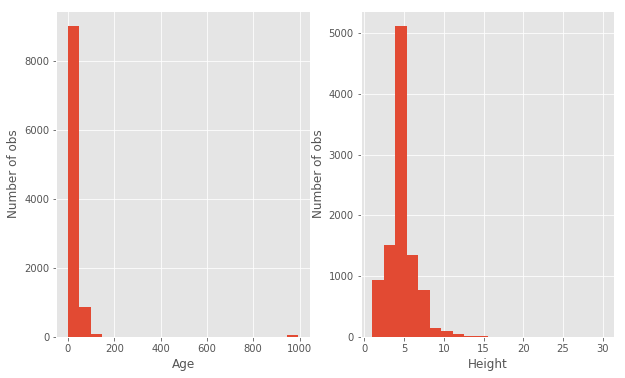

In [644]:
# plot the distributions to find out if they are Gaussian or skewed.
# Depending on the distribution, we will use the normal assummption or the interquantile range to find outliers
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
fig = train_data.age.hist(bins=20)
fig.set_ylabel('Number of obs')
fig.set_xlabel('Age')

plt.subplot(1, 2, 2)
fig = train_data.height.hist(bins=20)
fig.set_ylabel('Number of obs')
fig.set_xlabel('Height')

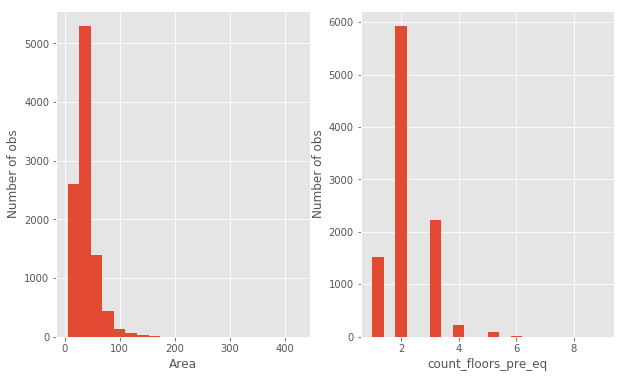

In [645]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
fig = train_data.area.hist(bins=20)
fig.set_ylabel('Number of obs')
fig.set_xlabel('Area')


plt.subplot(1, 2, 2)
fig = train_data.count_floors_pre_eq.hist(bins=20)
fig.set_ylabel('Number of obs')
fig.set_xlabel('count_floors_pre_eq')

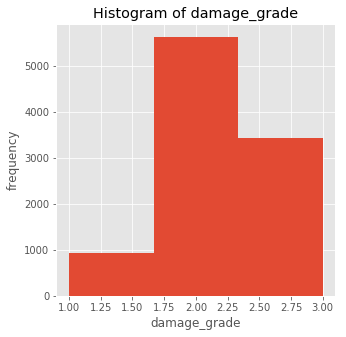

In [646]:
train_labels['damage_grade'].hist(bins=3, figsize=(5,5))
plt.ylabel('frequency')
plt.xlabel('damage_grade')
plt.title('Histogram of damage_grade')
plt.show()

In [647]:
# merge data frames
t = train_data[['building_id','age','height','area','count_floors_pre_eq']].merge(train_labels, on='building_id', how='inner')
t.head()

,building_id,age,height,area,count_floors_pre_eq,damage_grade
0,765,25,4,33,2,2
1,9470,15,5,28,3,3
2,14461,20,2,37,1,2
3,9317,5,3,18,2,2
4,15941,0,6,39,3,3


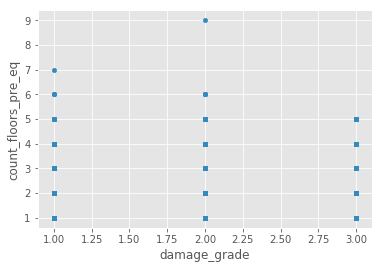

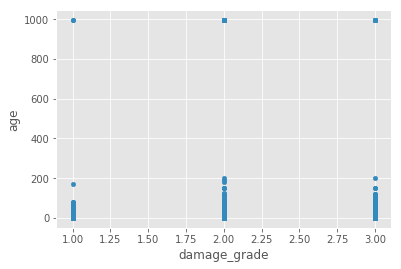

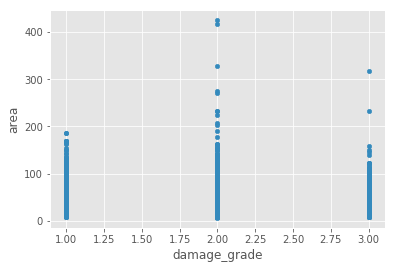

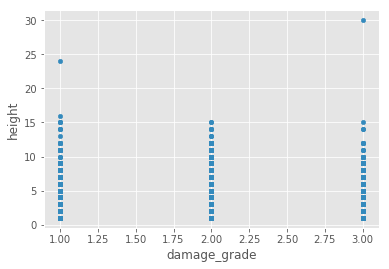

In [648]:
plt.style.use('ggplot')
t.plot.scatter(x='damage_grade', y='count_floors_pre_eq')
t.plot.scatter(x='damage_grade', y='age')
t.plot.scatter(x='damage_grade', y='area')
t.plot.scatter(x='damage_grade', y='height')
plt.show()

In [649]:
#t.groupby('damage_grade')['height'].mean().count(('damage_grade'))

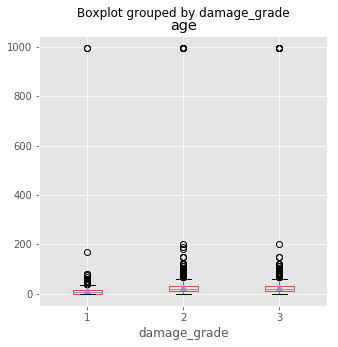

In [650]:
t.boxplot(column='age', by='damage_grade', figsize=(5,5), showmeans=True)
plt.show()

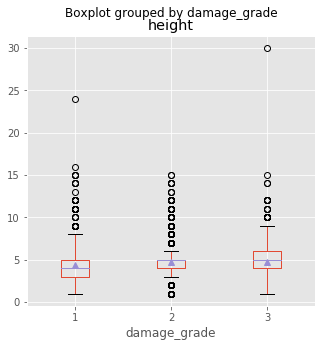

In [651]:
t.boxplot(column='height', by='damage_grade', figsize=(5,5), showmeans=True)
plt.show()

In [652]:
#train_data.head().transpose()

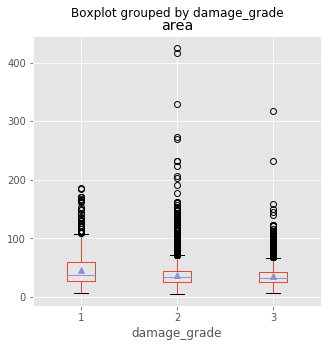

In [653]:
t.boxplot(column='area', by='damage_grade', figsize=(5,5), showmeans=True)
plt.show()

In [654]:
#get count of observations by target damage_grade
t.groupby(['damage_grade']).size().reset_index(name='counts')

,damage_grade,counts
0,1,938
1,2,5636
2,3,3426


In [664]:
#train_data.isnull().mean()

In [655]:
# plot the histograms to have a quick look at the distributions
# we can plot Q-Q plots to visualise if the variable is normally distributed

def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.show()
    
#diagnostic_plots(train_data, 'age')

### Determine data types

In [660]:
def get_type_lists(data_frame=train_data, rejects=['building_id']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.

    """
    nums, cats = [], []

    for col in data_frame.columns:
        if col not in rejects:
            type=data_frame[col].dtype
            if type in ('int64','int32','float64') :
                nums.append(col)
            elif str(type) in ('object')  :
                cats.append(col)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [661]:
original_nums, cats = get_type_lists()

Numeric = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area', 'height', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']

Categorical = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_

# Feature Engineering

In [663]:
# print variables with missing data
for col in original_nums:
    if train_data[col].isnull().mean()>0:
        print(col, train_data[col].isnull().mean())

In [665]:
# missing values with Zero
#test_data_x = test_data
for col in original_nums:
    train_data[col].fillna(0,inplace=True)
    test_data[col].fillna(0,inplace=True)

In [666]:
for col in cats:
    train_data[col].fillna('default',inplace=True)
    test_data[col].fillna('default',inplace=True)

In [667]:
train_data.shape, test_data.shape

((10000, 39), (10000, 39))

In [668]:
# how many labels in each variable

for col in train_data.columns:
    print(col, ': ', len(train_data[col].unique()), ' labels')

building_id :  10000  labels
geo_level_1_id :  31  labels
geo_level_2_id :  1137  labels
geo_level_3_id :  5172  labels
count_floors_pre_eq :  8  labels
age :  31  labels
area :  158  labels
height :  18  labels
land_surface_condition :  3  labels
foundation_type :  5  labels
roof_type :  3  labels
ground_floor_type :  5  labels
other_floor_type :  4  labels
position :  4  labels
plan_configuration :  9  labels
has_superstructure_adobe_mud :  2  labels
has_superstructure_mud_mortar_stone :  2  labels
has_superstructure_stone_flag :  2  labels
has_superstructure_cement_mortar_stone :  2  labels
has_superstructure_mud_mortar_brick :  2  labels
has_superstructure_cement_mortar_brick :  2  labels
has_superstructure_timber :  2  labels
has_superstructure_bamboo :  2  labels
has_superstructure_rc_non_engineered :  2  labels
has_superstructure_rc_engineered :  2  labels
has_superstructure_other :  2  labels
legal_ownership_status :  4  labels
count_families :  8  labels
has_secondary_use :  2

In [680]:
# replace each label in geo_level_1_id by its count

# first we make a dictionary that maps each label to the counts
X_frequency_map = train_data.geo_level_1_id.value_counts().to_dict()

# and now we replace geo_level_1_id labels both in train and test set with the same map
train_data.geo_level_1_id = train_data.geo_level_1_id.map(X_frequency_map)
test_data.geo_level_1_id = test_data.geo_level_1_id.map(X_frequency_map)

#train_data.head()

In [681]:
# replace each label in geo_level_2_id by its count

# first we make a dictionary that maps each label to the counts
X_frequency_map = train_data.geo_level_2_id.value_counts().to_dict()

# and now we replace geo_level_1_id labels both in train and test set with the same map
train_data.geo_level_2_id = train_data.geo_level_2_id.map(X_frequency_map)
test_data.geo_level_2_id = test_data.geo_level_2_id.map(X_frequency_map)

#train_data.head()

In [682]:
# replace each label in geo_level_3_id by its count

# first we make a dictionary that maps each label to the counts
X_frequency_map = train_data.geo_level_3_id.value_counts().to_dict()

# and now we replace geo_level_1_id labels both in train and test set with the same map
train_data.geo_level_3_id = train_data.geo_level_3_id.map(X_frequency_map)
test_data.geo_level_3_id = test_data.geo_level_3_id.map(X_frequency_map)

train_data.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area,height,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,765,559,6,2,2,25,33,4,d502,337f,...,0,0,0,0,0,0,0,0,0,0
1,9470,617,10,1,3,15,28,5,d502,337f,...,0,0,0,0,0,0,0,0,0,0
2,14461,194,17,2,1,20,37,2,d502,337f,...,0,1,0,0,0,0,0,0,0,0
3,9317,559,20,1,2,5,18,3,d502,337f,...,0,0,0,0,0,0,0,0,0,0
4,15941,90,16,3,3,0,39,6,d502,337f,...,0,0,0,0,0,0,0,0,0,0


In [683]:
train_data['geo_level_2_id'].fillna(0,inplace=True)
test_data['geo_level_2_id'].fillna(0,inplace=True)
train_data['geo_level_3_id'].fillna(0,inplace=True)
test_data['geo_level_3_id'].fillna(0,inplace=True)

In [684]:
train_data.shape, test_data.shape

((10000, 39), (10000, 39))

In [689]:
# Encoding categorical data in train set
for column in ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']:
    dummies = pd.get_dummies(train_data[column],drop_first=True)
    train_data[dummies.columns] = dummies

In [690]:
# Encoding categorical data in test set
for column in ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']:
    dummies = pd.get_dummies(test_data[column],drop_first=True)
    test_data[dummies.columns] = dummies

In [691]:
train_data.shape, test_data.shape

((10000, 66), (10000, 66))

In [692]:
#drop encoded categorical columns in train set and also geo_level_3_id
train_data=train_data.drop(['geo_level_3_id','land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'], axis=1)

In [693]:
#drop encoded categorical columns in test set
test_data=test_data.drop(['geo_level_3_id','land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'], axis=1)

In [694]:
train_data.shape, test_data.shape

((10000, 57), (10000, 57))

In [697]:
target = ['damage_grade']
train_labels = train_labels[target]

In [698]:
train_data.head().transpose()

,0,1,2,3,4
building_id,765.0,9470.0,14461.0,9317.0,15941.0
geo_level_1_id,559.0,617.0,194.0,559.0,90.0
geo_level_2_id,6.0,10.0,17.0,20.0,16.0
count_floors_pre_eq,2.0,3.0,1.0,2.0,3.0
age,25.0,15.0,20.0,5.0,0.0
area,33.0,28.0,37.0,18.0,39.0
height,4.0,5.0,2.0,3.0,6.0
has_superstructure_adobe_mud,0.0,0.0,0.0,0.0,0.0
has_superstructure_mud_mortar_stone,1.0,1.0,1.0,1.0,1.0
has_superstructure_stone_flag,0.0,0.0,0.0,0.0,0.0


In [700]:
train_data.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id',
       'count_floors_pre_eq', 'age', 'area', 'height',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', '808e', 'd502', '467b', '6c3e', '858b',
       'bb5f', '7e76', 'e

In [701]:
# after using onehotencoder the features in train and test do not match because of different categories in both sets
# source: https://stackoverflow.com/questions/34170413/possible-ways-to-do-one-hot-encoding-in-scikit-learn
# get the columns in train that are not in test
col_to_add = np.setdiff1d(train_data.columns, test_data.columns)

In [702]:
col_to_add

array([], dtype=object)

In [703]:
# add these columns to test, setting them equal to zero
for c in col_to_add:
    test_data[c] = 0

# select and reorder the test columns using the train columns
test_data = test_data[train_data.columns]

In [704]:
#missing columns added
col_to_add

array([], dtype=object)

In [706]:
train_data.shape, test_data.shape

((10000, 57), (10000, 57))

In [708]:
X_train=train_data
X_test=test_data

In [715]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((10000, 57), (10000, 57))

In [716]:
# re-assemble the dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Removing quasi-constant features
### Using variance threshold from sklearn

Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

Here, I will change the default threshold to remove almost / quasi-constant features.

In [718]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [719]:
# get_support is a boolean vector that indicates which features 
# are retained. If we sum over get_support, we get the number
# of features that are not quasi-constant
sum(sel.get_support())

42

In [720]:
features_to_keep = X_train.columns[sel.get_support()]

In [721]:
# finally we can print the quasi-constant features
print(
    len([
        x for x in X_train.columns
        if x not in X_train.columns[sel.get_support()]
    ]))

[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

15


['has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other',
 'bb5f',
 'e26c',
 '1442',
 '3fee',
 '6e81',
 'cb88',
 'd2d9']

In [722]:
# remove the features 
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((10000, 42), (10000, 42))

In [723]:
X_train= pd.DataFrame(X_train)
X_test= pd.DataFrame(X_test)
X_train.columns = features_to_keep
X_test.columns = features_to_keep

## Removing duplicate features

In [725]:
type(X_train)

pandas.core.frame.DataFrame

In [726]:
# transpose the dataframe, so that the columns are the rows of the new dataframe
data_t = X_train.T
data_t.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
building_id,765.0,9470.0,14461.0,9317.0,15941.0,4767.0,5117.0,4081.0,11259.0,5628.0,...,7751.0,16332.0,144.0,19279.0,7813.0,10955.0,17289.0,5192.0,12172.0,235.0
geo_level_1_id,559.0,617.0,194.0,559.0,90.0,860.0,256.0,860.0,860.0,292.0,...,134.0,903.0,523.0,97.0,903.0,37.0,617.0,292.0,292.0,523.0
geo_level_2_id,6.0,10.0,17.0,20.0,16.0,44.0,8.0,31.0,22.0,27.0,...,16.0,11.0,68.0,2.0,7.0,2.0,13.0,43.0,52.0,94.0
count_floors_pre_eq,2.0,3.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,...,1.0,3.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0
age,25.0,15.0,20.0,5.0,0.0,10.0,5.0,5.0,10.0,40.0,...,10.0,10.0,0.0,5.0,40.0,10.0,50.0,15.0,20.0,40.0


In [727]:
# check if there are duplicated rows (the columns of the original dataframe)
# this is a computionally expensive operation, so it might take a while
# sum indicates how many rows are duplicated

data_t.duplicated().sum()

0

In [728]:
# visualise the duplicated rows (the columns of the original dataframe)
data_t[data_t.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999


In [729]:
# we can capture the duplicated features, by capturing the
# index values of the transposed dataframe like this:
duplicated_features = data_t[data_t.duplicated()].index.values
duplicated_features

array([], dtype=object)

In [730]:
# alternatively, we can remove the duplicated rows,
# transpose the dataframe back to the variables as columns
# keep first indicates that we keep the first of a set of
# duplicated variables

data_unique = data_t.drop_duplicates(keep='first').T
X_train=data_unique
X_train.shape

(10000, 42)

In [731]:
X_test.drop(labels=duplicated_features,axis=1,inplace=True)
X_test.shape

(10000, 42)

In [732]:
# to find those columns in the original dataframe that were removed:
duplicated_features = [col for col in X_train.columns if col not in data_unique.columns]
duplicated_features 

[]

In [733]:
# find and remove correlated features
# to reduce the feature space

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.75)
print('correlated features: ', len(set(corr_features)) )

correlated features:  6


In [734]:
# re-assemble the dataframe
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)

X_train.shape, X_test.shape

((10000, 42), (10000, 42))

In [735]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

In [736]:
X_train.shape, X_test.shape

((10000, 36), (10000, 36))

In [737]:
# re-assemble the dataframe
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)

### Remove features using univariate roc_auc

In [705]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [743]:
# step backward greedy selection algorithm

sfs1 = SFS(RandomForestClassifier(n_jobs=4), 
           k_features=32, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=3)

sfs1 = sfs1.fit(np.array(X_train), train_labels.values.ravel())

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   25.5s finished

[2018-04-22 16:40:37] Features: 35/32 -- score: 0.617801589742[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   25.1s finished

[2018-04-22 16:41:03] Features: 34/32 -- score: 0.623700830062[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   24.2s finished

[2018-04-22 16:41:27] Features: 33/32 -- score: 0.622701930202[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   23.5s finished

[2018-04-22 16:41:50] Features: 32/32 -- score: 0.625600930234

In [744]:
sfs1.k_feature_idx_

(1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 29,
 30,
 32,
 33,
 34,
 35)

In [747]:
X_train.columns[list(sfs1.k_feature_idx_)]

Index(['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq', 'age',
       'area', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_hotel',
       '808e', '467b', '6c3e', '858b', '7e76', 'b1b4', '67f9', 'f962', '3356',
       '84cf', '8e3f', 'a779', 'c8e1'],
      dtype='object')

#### Function to generate submission file

In [748]:
import re
import time

def gen_submission():
    """ Generates submission file for contest.
    :param model: Model with which to score test data.
    :param test: Test data.
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())    
    # save file for submission
    sub_fname = 'Nepalsubmission_' + time_stamp + '.csv'
    # Create a submission file
    # Save submission to CSV
    #submission.to_csv(sub_fname, index=False)        # Do not save index values    
    i=0
    file=open(sub_fname,'w')
    header="building_id,damage_grade"
    header=header+'\n'
    file.write(header)
    for id in (test_data['building_id']):
        str="{},{}".format(id,test_prediction[i].item())
        str=str+'\n'
        #print(predval)
        file.write(str)
        i+=1


In [750]:
#drop building id
X_train=X_train.drop(['building_id'], axis=1)
X_test=X_test.drop(['building_id'], axis=1)

### Split the Dataset into Training and Test Datasets

In [752]:
from sklearn.model_selection import train_test_split
X_train, X_traintest, y_train, y_test = train_test_split(X_train, train_labels, test_size=0.30, random_state=0)

In [754]:
# Get rid of outliers in the train set
X_train.loc[X_train.age>=90, 'age']=90  # select the boundary of the Gaussian assumption, refer to NepalOutliers notebook
#X_train.loc[X_train.height > 10, 'height']=10 # select the boundary of the IQR assumption, refer to NepalOutliers notebook

In [755]:
# Source: https://beckernick.github.io/oversampling-modeling/
#damage_grade 2 has 5636 obs, damage_grade 3 has 3426 and damage_grade 1 has 938 causing an imbalance in the model
from imblearn.over_sampling import SMOTE

In [756]:
# create observations so that damage_grade will be balanced (have same number of observations)
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [757]:
X_train=x_train_res
y_train=y_train_res
X_train.shape, y_train.shape

((11850, 35), (11850,))

In [758]:
# re-assemble the dataframe
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)
y_train = pd.DataFrame(data=y_train)

In [764]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [765]:
# calculate the mutual information between the variables and the target
# this returns the mutual information value of each feature
# the smaller the value the less information the feature has about the
# target
mi = mutual_info_classif(X_train, y_train)
mi

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0.23004604,  0.24928235,  0.16482858,  0.25200175,  0.27422633,
        0.03354179,  0.17302582,  0.01895374,  0.02314158,  0.02317243,
        0.11608356,  0.06241208,  0.03680076,  0.06171703,  0.04835261,
        0.01067312,  0.08114387,  0.05412187,  0.02683268,  0.04458622,
        0.11095009,  0.05591233,  0.06727128,  0.09277506,  0.13332072,
        0.03383455,  0.08320637,  0.05156488,  0.14068187,  0.07107376,
        0.02862583,  0.        ,  0.01612152,  0.01958058,  0.02732832])

In [766]:
# add the variable names and order the features
# according to the MI for clearer visualisation
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False)

4     0.274226
3     0.252002
1     0.249282
0     0.230046
6     0.173026
2     0.164829
28    0.140682
24    0.133321
10    0.116084
20    0.110950
23    0.092775
26    0.083206
16    0.081144
29    0.071074
22    0.067271
11    0.062412
13    0.061717
21    0.055912
17    0.054122
27    0.051565
14    0.048353
19    0.044586
12    0.036801
25    0.033835
5     0.033542
30    0.028626
34    0.027328
18    0.026833
9     0.023172
8     0.023142
33    0.019581
7     0.018954
32    0.016122
15    0.010673
31    0.000000
dtype: float64

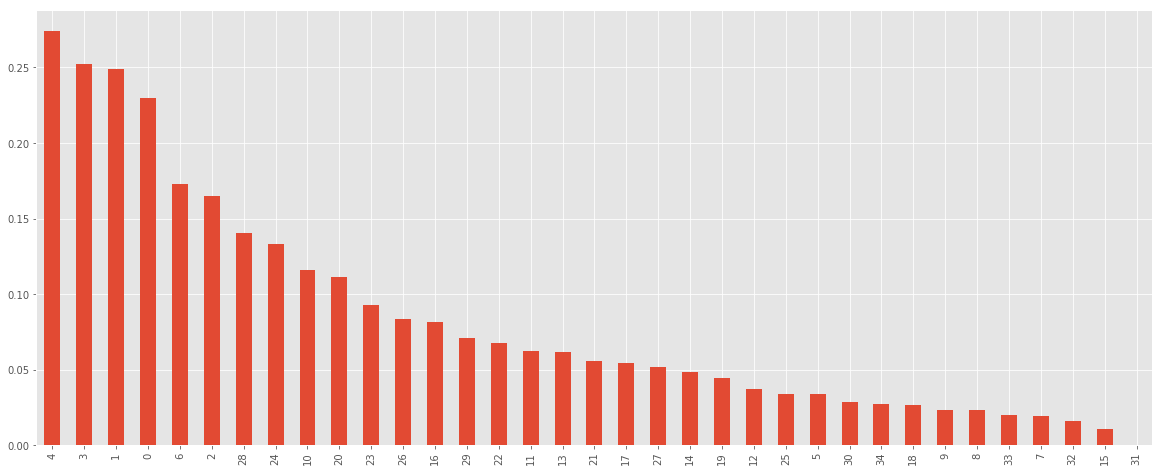

In [767]:
# lot the ordered MI values per feature
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [768]:
# select the top 15 features which are shown below
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_train.fillna(0), y_train)
X_train.columns[sel_.get_support()]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Int64Index([0, 1, 2, 3, 4, 6, 10, 13, 16, 20, 22, 23, 24, 26, 28], dtype='int64')

In [769]:
from sklearn.feature_selection import SelectFromModel
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel_.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [770]:
sel_.get_support()

array([ True,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True, False, False, False, False, False, False], dtype=bool)

In [771]:
# make a list and count the selected features
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

11

In [772]:
selected_feat

Int64Index([0, 1, 2, 3, 4, 6, 11, 22, 23, 24, 28], dtype='int64')

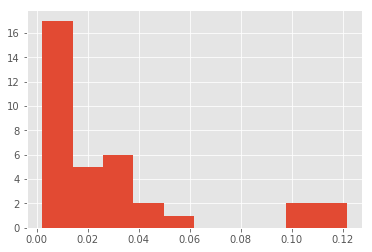

In [773]:
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist()

In [774]:
# compare the  amount of selected features with the amount of features which importance is above the
# mean importance, to make sure we understand the output of sklearn
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(sel_.estimator_.feature_importances_ > sel_.estimator_.feature_importances_.mean())))

total features: 35
selected features: 11
features with coefficients greater than the mean coefficient: 11


In [780]:
# calculate the univariate statistical measure between each of the variables and the target
# similarly to chi2, the output is the array of f-scores
# and an array of pvalues, which are the ones we will compare
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
univariate = f_classif(X_train.fillna(0), y_train)
univariate

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([  9.41713035e+01,   2.89807902e+02,   2.62752637e+02,
          7.70816404e+02,   2.36916894e+02,   1.30284149e+02,
          1.78843463e+03,   4.77301255e+01,   6.32326104e+01,
          4.59868021e+01,   8.19226200e+02,   6.30112462e+01,
          3.93037496e+01,   4.22319595e+02,   4.79593218e+02,
          7.69091079e-01,   3.17932885e+01,   1.04906456e+02,
          1.06911699e+02,   1.48518986e+01,   1.09262526e+03,
          2.29060815e+02,   3.86200856e+02,   2.05588021e+02,
          1.16059076e+03,   7.66943278e-02,   7.78294545e+02,
          5.42016900e+00,   9.61336529e+02,   2.10913415e+00,
          1.34171874e+01,   6.66655543e+00,   2.51711532e+01,
          5.68907902e+00,   3.58217633e+01]),
 array([  2.65225101e-041,   1.31842525e-123,   2.22030853e-112,
          1.98255456e-315,   1.29617504e-101,   1.07542123e-056,
          0.00000000e+000,   2.26015539e-021,   4.83020779e-028,
          1.27441766e-020,   0.00000000e+000,   6.01297502e-028,
          9.

In [781]:
# add the variable names and order it for clearer visualisation
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False, inplace=True)

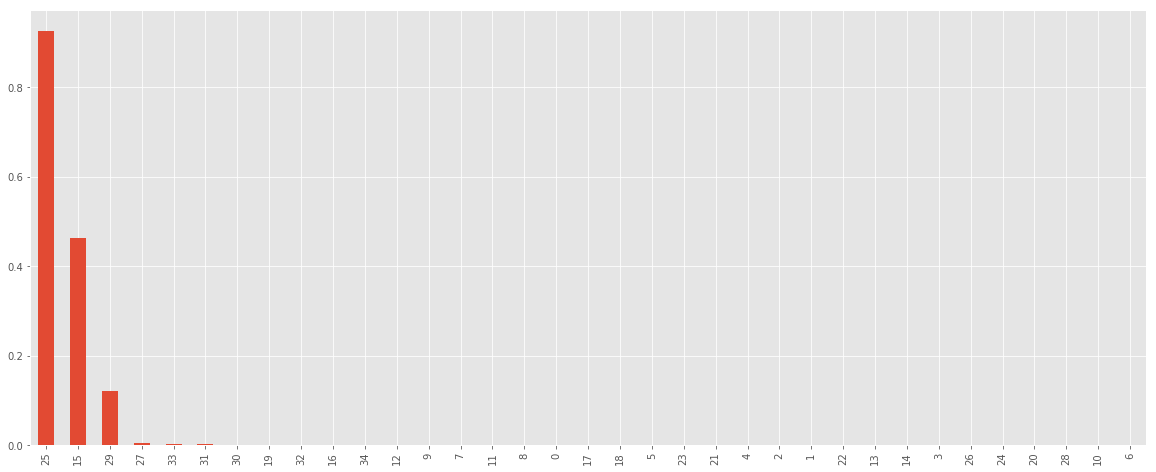

In [782]:
# plot the p values
univariate.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [783]:
# select the top 25 features
sel_ = SelectKBest(f_classif, k=25).fit(X_train.fillna(0), y_train)
X_train.columns[sel_.get_support()]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 18,
            20, 21, 22, 23, 24, 26, 28, 34],
           dtype='int64')

In [784]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#training_vars=[0,  1,  2, 3, 4,  5, 6, 9, 10, 12, 13, 14, 18, 21, 22, 23, 25, 26, 27, 29,36, 39,40, 41, 42, 43, 44, 45, 47,48, 49,50,52, 56]
#X_train = sc.fit_transform(X_train[training_vars])
X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test[training_vars])
X_test = sc.transform(X_test)
#X_traintest = sc.transform(X_traintest[training_vars])
X_traintest = sc.transform(X_traintest)

In [785]:
# re-assemble the dataframe
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)

In [792]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
classifier = RandomForestClassifier(n_estimators = 950, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=950, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [793]:
# Predicting the Test set results
y_pred = classifier.predict(X_traintest)

In [796]:
accuracy_score(y_true = y_test, y_pred = y_pred)

0.6343333333333333

In [797]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 100,  177,   10],
       [  72, 1287,  327],
       [   9,  502,  516]])

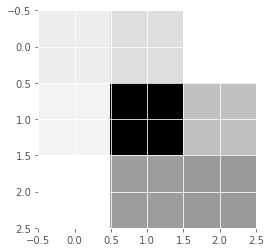

In [798]:
#import matplotlib.pyplot as plt
#conf = sklearn.metrics.confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='binary', interpolation='None')
plt.show()

In [799]:
#sns.heatmap(cm, annot=True)
X_train.shape, y_train.shape 

((11850, 35), (11850, 1))

In [801]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train[0], cv = 3)
accuracies.std()

0.10237772127636303

In [802]:
accuracies.mean()

0.7740084388185654

In [803]:
test_prediction = classifier.predict(X_test)

In [804]:
gen_submission()

In [805]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=0), n_estimators=950, max_samples=2000, bootstrap=True, n_jobs=-1, random_state=0)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_traintest)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [806]:
accuracy_score(y_true = y_test, y_pred = y_pred)

0.65833333333333333

In [807]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 130,  150,    7],
       [ 101, 1276,  309],
       [  10,  448,  569]])

In [808]:
test_prediction = bag_clf.predict(X_test)

In [809]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = bag_clf, X = X_train, y = y_train[0], cv = 10)
accuracies.std()

0.080537857938179941

In [810]:
accuracies.mean()

0.76210970464135019

In [811]:
test_prediction = bag_clf.predict(X_test)

In [812]:
gen_submission()

In [816]:
# re-assemble the dataframe
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)
X_traintest = pd.DataFrame(data=X_traintest)

In [822]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train, eval_metric="auc", verbose=False)
y_pred = xgb_model.predict(X_traintest)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [823]:
# Predicting the Test set results
y_pred = xgb_model.predict(X_traintest)

In [824]:
accuracy_score(y_true = y_test, y_pred = y_pred)

0.64600000000000002

In [826]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgb_model, X = X_train, y = y_train[0], cv = 3)
accuracies.mean()

0.740759493670886

In [827]:
test_prediction = xgb_model.predict(X_test)

In [828]:
#gen_submission()

In [829]:
bag_clf = BaggingClassifier(xgb.XGBClassifier(), n_estimators=950, max_samples=2000, bootstrap=True, n_jobs=-1, random_state=0)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_traintest)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [830]:
accuracy_score(y_true = y_test, y_pred = y_pred)

0.64166666666666672

In [831]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = bag_clf, X = X_train, y = y_train[0], cv = 3)
accuracies.std()

0.090196952012476919

In [832]:
accuracies.mean()

0.74546739661243466

In [834]:
gen_submission()